In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Explore the data
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1ee487bdfc0>,
 'prcp': 0.08,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397'}

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date = recent_date[0]
recent_date

'2017-08-23'

In [11]:
# Determe the date 12 months before the last date 
last_date = dt.datetime.strptime('2017-08-23','%Y-%m-%d') - dt.timedelta(days = 365)
last_date = last_date.strftime('%Y-%m-%d')
last_date


'2016-08-23'

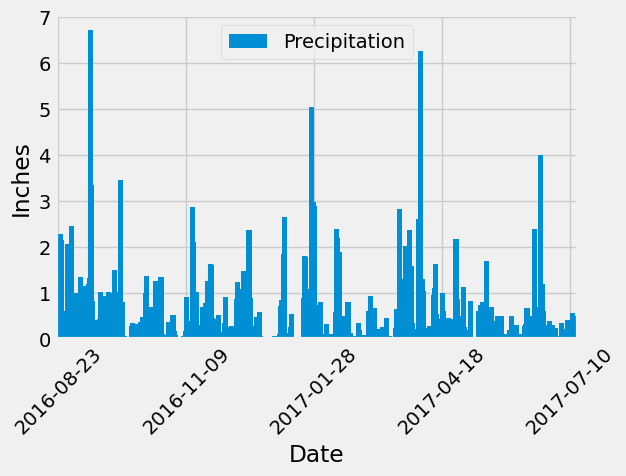

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime('2017-08-23','%Y-%m-%d') - dt.timedelta(days = 365)
last_date = last_date.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
scores = session.query(measurement.date, measurement.prcp).filter(measurement.date <= '2017-08-23').filter(measurement.date >= '2016-08-23').all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
results = pd.DataFrame(scores).set_index('date')
results = results.rename(columns={'prcp' : 'Precipitation'})


# Sort the dataframe by date
results = results.sort_values(by = 'date').dropna()

# Use Pandas Plotting with Matplotlib to plot the data
results.plot(kind='bar', width=20, figsize=(6,4), rot = 45)
labels = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
plt.xticks(ticks=[0, 500, 1000, 1500, 2000], labels=labels)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
results['Precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [14]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1ee4d797f40>,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0}

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station).count()
total_stations

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations_count = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
stations_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = stations_count[0][0]
temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == active_station).all()
temps

[(54.0, 85.0, 71.66378066378067)]

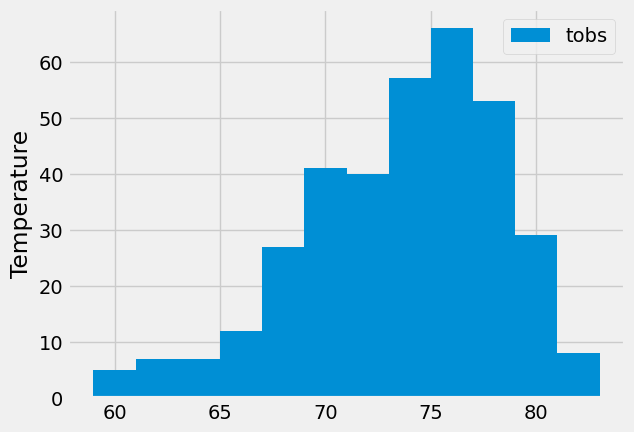

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observations = session.query(measurement.station, measurement.tobs).filter(measurement.station ==active_station).filter(measurement.date <= recent_date).filter(measurement.date >=last_date).all()
observations_df =pd.DataFrame(observations).set_index('station')
observations_df.plot(kind='hist', bins=12)
plt.ylabel('Temperature')
plt.show()

# Close Session

In [19]:
# Close Session
session.close()